# 1. Introduction

![](https://image.cnbcfm.com/api/v1/image/105611441-1544204687419bostonmassachusetts.jpg?v=1544204740&w=1910)

Airbnb is an online marketplace for arranging or offering lodging, primarily homestays, or tourism experiences. Since 2008, guests and hosts have used Airbnb to expand on traveling possibilities. It renders an unique and personalized way of experiencing the world and socializing with new people. This dataset describes the listing activity and metrics in Boston, MA for 2019. This data file includes all needed information to find out more about hosts, geographical availability, necessary metrics to make predictions and draw conclusions. What can we learn about AirBnB rentals if we try to model their price? 
The analysis could provide some insights on:
1. What features affect the price? By how much?
2. The popular description words in different price groups. 

I hope you like this kernel and your UPVOTES would be appreciate :)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
sns.set_style('darkgrid')

In [3]:
# import data to dataframes
list_df = pd.read_csv('../input/boston/listings.csv')

# 2. EDA

In [4]:
# Copy the dataframe
list_clean = list_df.copy()

In [5]:
# First, let's drop some columns that are not useful for analysis
cols = ['thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'listing_url', 'host_url',
       'host_thumbnail_url', 'host_picture_url', 'country', 'country_code', 'neighbourhood',
       'smart_location', 'street', 'market', 'first_review', 'last_review', 'state', 'calendar_last_scraped',
       'calendar_updated', 'city', 'scrape_id', 'last_scraped', 'space', 'host_neighbourhood', 
        'neighborhood_overview', 'host_listings_count', 'zipcode', 'is_location_exact', 'host_location',
       'host_total_listings_count']
list_clean.drop(cols, axis=1, inplace=True)

In [6]:
# drop the colunms with more than half of the missing value
cols = list_clean.columns[list_clean.isnull().sum()/list_clean.shape[0] > 0.5]
list_clean.drop(cols, axis=1, inplace=True)

In [7]:
# Next, let's fix some datatype errors, extract numbers and change to int type
cols = ['host_response_rate', 'host_acceptance_rate', 'price', 'cleaning_fee', 'extra_people']
for col in cols:
    list_clean[col] = list_clean[col].str.extract(r'(\d+)')
    list_clean[col] = list_clean[col].astype('float128').astype('Int64')
list_clean[cols].dtypes

host_response_rate      Int64
host_acceptance_rate    Int64
price                   Int64
cleaning_fee            Int64
extra_people            Int64
dtype: object

In [8]:
# Change datatype for host_since
list_clean['host_since'] = pd.to_datetime(list_clean.host_since)
temp = pd.to_datetime('12/31/2019')

In [9]:
list_clean['host_len'] = list_clean.host_since.apply(lambda x: pd.Timedelta(temp-x).days)
list_clean = list_clean.drop('host_since', axis=1)

In [10]:
# extract the number of amenities 
list_clean['n_amenities'] = list_clean['amenities'].apply(lambda x: len(x.replace('{', '').\
                        replace('{', '').replace('"', '').split(',')))
list_clean.drop('amenities', axis=1, inplace=True)

In [11]:
df_num = list_clean.select_dtypes(include=['int', 'float'])

In [12]:
# fill na for the columns
int_fillmean = lambda x: x.fillna(round(x.mean()))
df_num = df_num.apply(int_fillmean, axis=0)
df_num = df_num.drop(['id', 'host_id', 'latitude', 'longitude'], axis=1).astype(float)

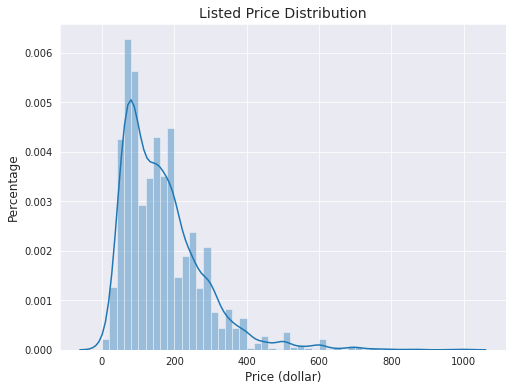

In [13]:
# visualizae the price
plt.figure(figsize=(8, 6))
sns.distplot(df_num['price'], bins=50, kde=True)
plt.ylabel('Percentage', fontsize=12)
plt.xlabel('Price (dollar)', fontsize=12)
plt.title('Listed Price Distribution', fontsize=14);

In [14]:
# we can see that some listed price are 1 dollar, which is not intuitive
df_num = df_num[df_num['price'] != 1]
# we will also exlude some outliers of the price > 1.5 IQR
df_num = df_num[df_num['price'] < 423]

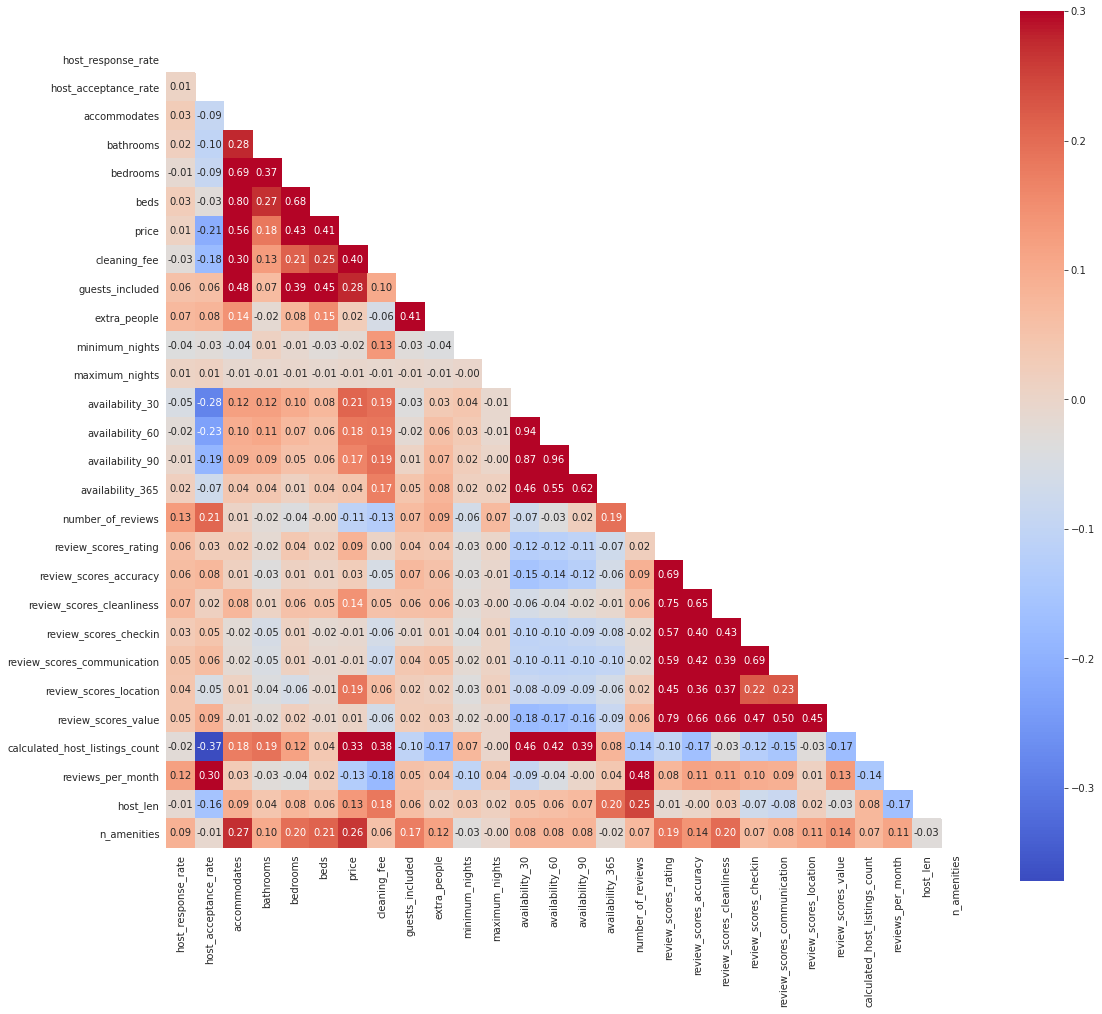

In [15]:
# visualize the correlation matrix
corr = df_num.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(18, 16))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True, fmt='.2f', cmap='coolwarm')

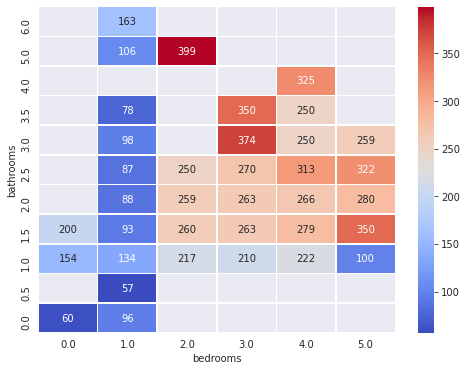

In [16]:
# visualizae the price
plt.figure(figsize=(8, 6))
sns.heatmap(df_num.groupby(['bathrooms', 'bedrooms']).mean()['price'].reset_index()\
                .pivot('bathrooms', 'bedrooms', 'price').sort_index(ascending=False),
            cmap="coolwarm", fmt='.0f', annot=True, linewidths=0.5);

In [17]:
# Next let's look at the categorical values
df_cat = list_clean.select_dtypes(include=['object'])
# we will drop few description lines for future analysis
df_cat = df_cat.drop(['name', 'summary', 'description', 'experiences_offered', 'host_about', 
                      'host_verifications', 'host_name'], axis=1)

The interaction, house_rules, access can substantial a listing post. Maybe provide the information would attract more people and pontentially inrease the value of the listing. Since there are a lot of missing values in these columns, I would categorize them with t (with info) and f (without info). 

In [18]:
# find the not na rows with True
df_cat['with_inter'] = df_cat.interaction.notna().astype('object')
df_cat['with_access']= df_cat.access.notna().astype('object')
df_cat['with_rules'] = df_cat.house_rules.notna().astype('object')
df_cat['with_transit'] = df_cat.transit.notna().astype('object')
df_cat = df_cat.drop(['transit', 'access', 'interaction', 'house_rules'], axis=1)

In [19]:
df_cat = pd.concat([df_cat, list_clean.price], axis=1)
df_cat = df_cat[df_cat['price'] != 1]
df_cat = df_cat[df_cat['price'] < 423]

In [20]:
# get dummy values for categorical features
df_cat_dummies = pd.get_dummies(df_cat.iloc[:,:-1], dummy_na=False)

In [21]:
# concatenate the model df
df_mod = pd.concat([df_num, df_cat_dummies], axis=1)

# 3. Popular Word and Word Cloud

## Popular word

In [22]:
# We will first extract the dataframe for word analysis
df_word = list_clean.loc[:,['description', 'price']]
df_word = df_word[df_word.price!=1] 
df_word = df_word[df_word.price<423] 
df_word.sample(5)

,description,price
2474,"Great location, above a subway stop. Walking d...",260
226,We will be happy to share for few days our two...,100
3197,Completely Brand New Construction | 2 BR | 1 B...,185
1031,1&2 nites sometimes possible Ask! Studio for 2...,183
2926,Private room shared kitchen and bathroom with ...,49


In [23]:
# segment price into two groups 
bin_edges = [0, 84, 145, 205, 417]
bin_name = ['25%', '50%', '75%', '100%']
df_word['price_bin'] = pd.cut(df_word['price'], bins=bin_edges, labels=bin_name)

In [24]:
# get the post content for each price group
p_words = {};
for i in range(len(bin_name)):
    p_words[i] = ''
    df_i = df_word[df_word['price_bin'] == bin_name[i]]['description'].astype(str)
    for j in range(len(df_i)):
        words = df_i.iloc[j].split(' ')
        for word in words:
            p_words[i] += word+' '

In [25]:
# Get the most popular 20 words for each price group 
from collections import Counter
import string
counter = {}
occur = {}
stop_words = ['a', 'the', 'and', 'is', 'of', 'with', '', 'in', 'i', 'you', 'for', 'on', 'at', 'this', 'there', 
              'that', 'to', 'from', 'have', 'has', 'we', 'your', 'my', 'are', 'be', 'or', 'will', 'our', 'it',
             'located', 'all', 'as']
for i in range(len(bin_name)):
    words = p_words[i].lower().translate(str.maketrans('', '', string.punctuation)).split(' ')
    counter[i] = Counter([word for word in words if word not in stop_words])
    occur[i] = counter[i].most_common(20)
    
df1 = pd.DataFrame.from_dict(occur[0]).rename(columns={0:'word', 1:'count'})
df2 = pd.DataFrame.from_dict(occur[1]).rename(columns={0:'word', 1:'count'})
df3 = pd.DataFrame.from_dict(occur[2]).rename(columns={0:'word', 1:'count'})
df4 = pd.DataFrame.from_dict(occur[3]).rename(columns={0:'word', 1:'count'})

In [26]:
pd.DataFrame.from_dict(occur).rename(columns={0:'0%-25%', 1:'25%-50%', 2:'50%-75%', 3:'75%-100%'})

,0%-25%,25%-50%,50%-75%,75%-100%
0,"(room, 1389)","(boston, 1065)","(boston, 1145)","(boston, 1096)"
1,"(boston, 862)","(room, 952)","(apartment, 916)","(apartment, 975)"
2,"(kitchen, 673)","(apartment, 740)","(kitchen, 636)","(kitchen, 643)"
3,"(walk, 627)","(walk, 680)","(walk, 605)","(bedroom, 627)"
4,"(apartment, 536)","(kitchen, 621)","(bedroom, 600)","(room, 598)"
5,"(house, 504)","(bedroom, 591)","(room, 575)","(bed, 533)"
6,"(access, 451)","(private, 550)","(bed, 522)","(living, 508)"
7,"(line, 450)","(bed, 528)","(one, 489)","(•, 501)"
8,"(bed, 448)","(access, 480)","(street, 484)","(walk, 495)"
9,"(place, 441)","(bathroom, 437)","(living, 451)","(2, 422)"


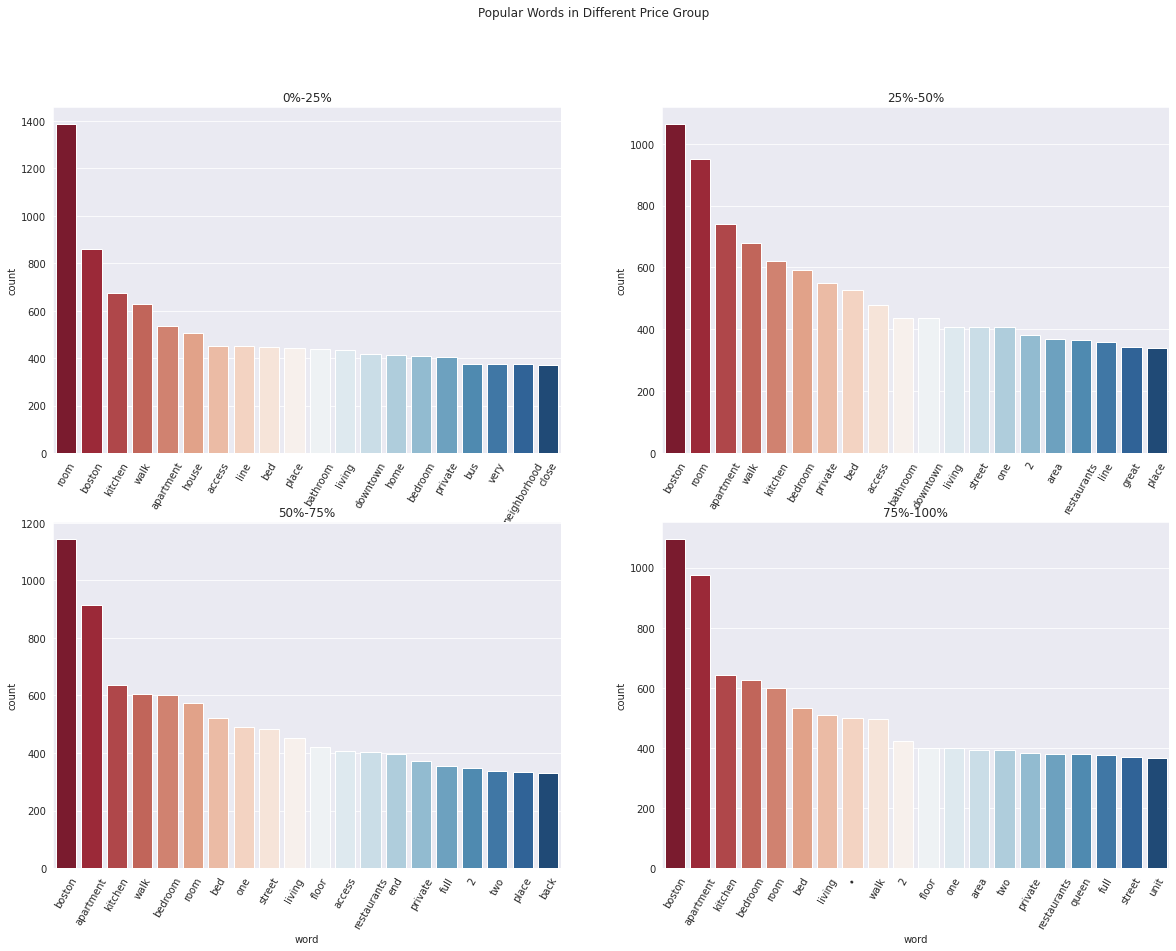

In [27]:
# visualization 
plt.figure(figsize=(20, 14))
plt.subplot(2, 2, 1)
ax1 = sns.barplot(data=df1, x='word', y='count', palette = 'RdBu')
plt.xticks(rotation=60)
plt.xlabel('')
plt.title('0%-25%', fontsize=12);

plt.subplot(2, 2, 2)
ax2 = sns.barplot(data=df2, x='word', y='count', palette = 'RdBu')
plt.xticks(rotation=60)
plt.xlabel('')
plt.title('25%-50%', fontsize=12)

plt.subplot(2, 2, 3)
ax2 = sns.barplot(data=df3, x='word', y='count', palette = 'RdBu')
plt.xticks(rotation=60)
plt.title('50%-75%', fontsize=12)

plt.subplot(2, 2, 4)
ax2 = sns.barplot(data=df4, x='word', y='count', palette = 'RdBu')
plt.xticks(rotation=60)
plt.title('75%-100%', fontsize=12)

plt.suptitle('Popular Words in Different Price Group');

There a a lot of overlapping in different price groups, one thing that is interesting is that the higher priced listings contains 'restuarants' more frequently, while lower price listings emphasize transportation using words such as 'bus' and 'line' (metro). 

## Word Cloud

In [28]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopwords = set(STOPWORDS)
stopwords.update(stop_words)

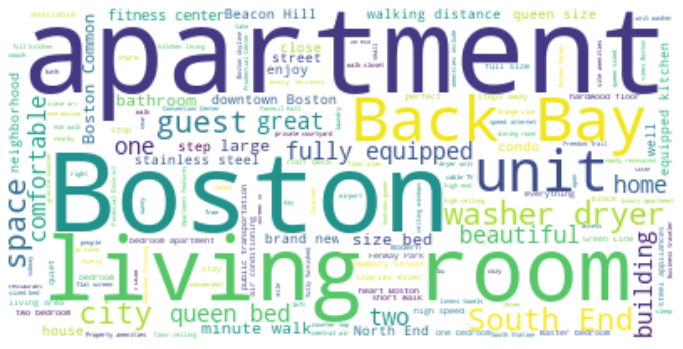

In [29]:
# generate word cloud for high price group
wordcloud = WordCloud(background_color='white', max_words=1000, contour_width=3,contour_color='firebrick', 
                      stopwords = stopwords)

wordcloud.generate(p_words[3])
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

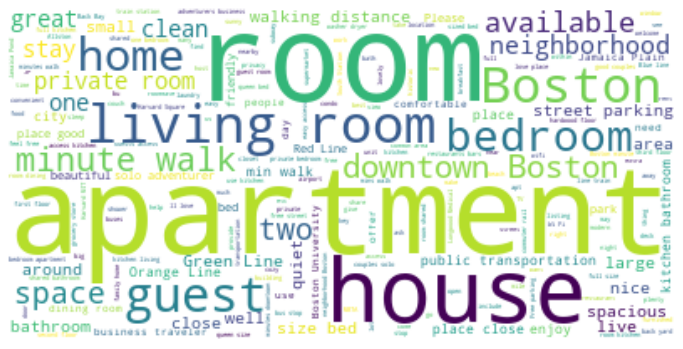

In [30]:
# generate word cloud for low price group
wordcloud = WordCloud(background_color='white', max_words=1000, contour_width=3,contour_color='firebrick', 
                      stopwords = stopwords)

wordcloud.generate(p_words[0])
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Looking at the word cloud, it is interesting that the more expensive listings contains more information about the amenities, such as dryer and washer and fully-equipped, and they also emphasize the location (south end, back bay) more frequentyly.

# 4. Model Build

## Feature selection and Linear model

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

In [32]:
# get the feature and label
X = df_mod.drop('price', axis=1)
y = df_mod['price']

In [33]:
# There are two many features, let's select top 30 features with REF model
n = np.arange(5, 100, 5)
model = LinearRegression()
R2 = []
#Initializing RFE model
for num in n:
    rfe = RFE(model, num)
    #Transforming data using RFE
    X_rfe = rfe.fit_transform(X,y)  
    #Fitting the data to model
    model.fit(X_rfe,y)
    # generate new feature matrix
    X_new = X.iloc[:,rfe.support_]
    # split training and testing model
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)
    # fit the data
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    pred = lm.predict(X_test)
    R2.append(metrics.r2_score(y_test, pred))

In [34]:
ind = np.array(R2).argmax()
f_n = n[ind]
rfe = RFE(model, f_n)
X_rfe = rfe.fit_transform(X,y) 
model.fit(X_rfe,y)
X_new = X.iloc[:,rfe.support_]
print('{} features are selected'.format(f_n))

95 features are selected


In [35]:
# split training and testing model
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)

In [36]:
# fit the data
lm = LinearRegression()
lm.fit(X_train, y_train)
pred = lm.predict(X_test)

In [37]:
# evaluate
mse = metrics.mean_squared_error(y_test, pred)
r_square = metrics.r2_score(y_test, pred)

print('Mean absolute error is {}'.format(mse))
print('R^2 is {}'.format(r_square))

Mean absolute error is 2599.7598830657403
R^2 is 0.6675173286542571


In [38]:
# create a function to visualize the distribution of the prediction and the test
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    plt.figure(figsize=(10, 8))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)
    plt.title(Title)
    plt.xlabel('Price (dollars)')
    plt.show()
    plt.close()

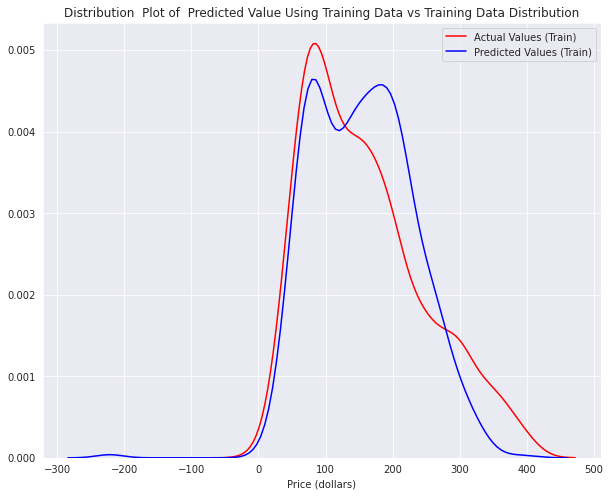

In [39]:
# Visualize the results
DistributionPlot(y_test, pred, 'Actual Values (Train)', 'Predicted Values (Train)', 
                 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution')

## Cross-Validation

In [40]:
Rcross = cross_val_score(lm, X_new, y, cv=10)
print("The mean of the folds are", Rcross.mean(), "and the standard deviation is" , Rcross.std())

The mean of the folds are 0.5060307082542472 and the standard deviation is 0.1452200337417806


## Ridge Regression

In [41]:
# screen ridge model
RR_square = []
RR_train = []
alpha = [0.0001, 0.001, 0.1, 1, 10, 20]
for a in alpha:
    RigeModel = Ridge(alpha=a) 
    RigeModel.fit(X_train, y_train)
    RR_square.append(RigeModel.score(X_test, y_test))
    RR_train.append(RigeModel.score(X_train, y_train))

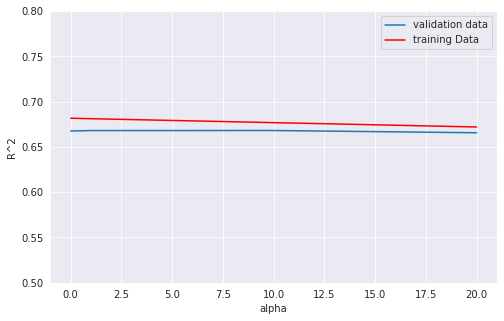

In [42]:
# visualize
plt.figure(figsize=(8, 5))
plt.plot(alpha,RR_square, label='validation data')
plt.plot(alpha,RR_train, 'r', label='training Data')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.ylim(0.5, 0.8)
plt.legend();

In [43]:
# Choose a ridge
RigeModel = Ridge(alpha=5) 
RigeModel.fit(X_train, y_train)
rr_pred = RigeModel.predict(X_test)
print('r2 score is: {}'.format(RigeModel.score(X_test, y_test)))

r2 score is: 0.6685482044775237


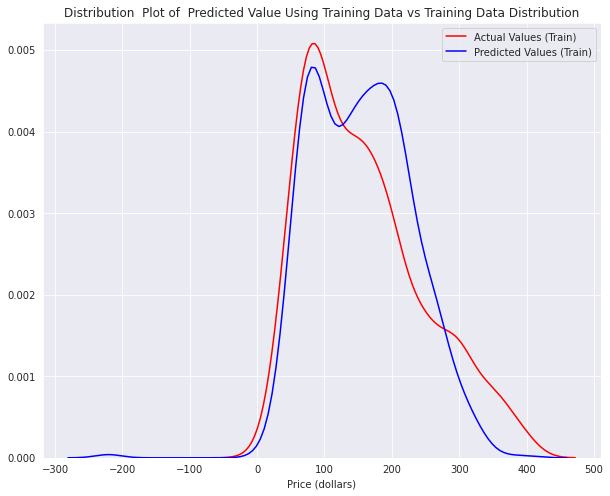

In [44]:
# Visualize the results
DistributionPlot(y_test, rr_pred, 'Actual Values (Train)', 'Predicted Values (Train)', 
                 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution')

We can see that ridge only slightly improve the model...

# 5. Conclusion

In [45]:
coef_df = pd.DataFrame(data=list(lm.coef_), index=X_new.columns).reset_index().rename(columns={'index': 'Var', 0: 'Coef'})

1. According to our model, every additional bedroom will cost extra 28.5 dollars, while each additional bathroom will cost extra 2.3 dollars. Each additional guests will cost 6 dollars more.

2. Real bed costs more than alternative options.

3. Neighbourhood areas strongly bias the price, which will be plot next.

4. Superhosts' listings are 6 dollars more expensive on average. 

5. Property types strongly affect the price. For example: a camp/RV will cost 150 dollars less on average but a boat will cost 39.7 dollars more on average.

6. Entire room on average will cost 76.6 more than a shared-room.

7. In general, the more strict the cacellation policy is, the more expensive the listing will be. Maybe listings have strict cancellation policy are tend to be more expensive and popular. 

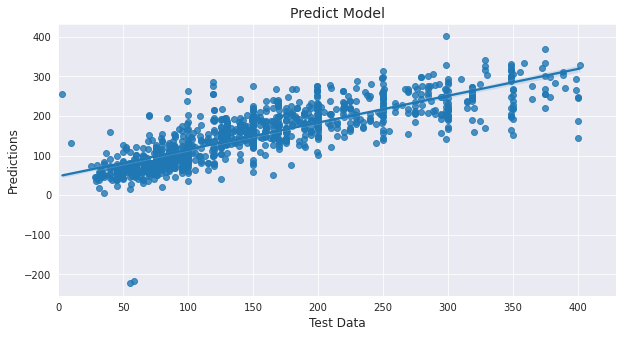

In [46]:
# Predicted prive VS. actural price 
plt.figure(figsize=(10,5))
sns.regplot(x=y_test, y=rr_pred, color=sns.color_palette()[0])
plt.xlim(0, 430)
plt.title('Predict Model', fontsize=14)
plt.xlabel('Test Data', fontsize=12)
plt.ylabel('Predictions', fontsize=12);

In [47]:
# get the neighboorhood
neighborhoods = coef_df[coef_df.Var.str.contains('neighbourhood')].sort_values(by='Coef', ascending=False)
neighborhoods['Var'] = neighborhoods['Var'].apply(lambda x: x.split('_')[2])

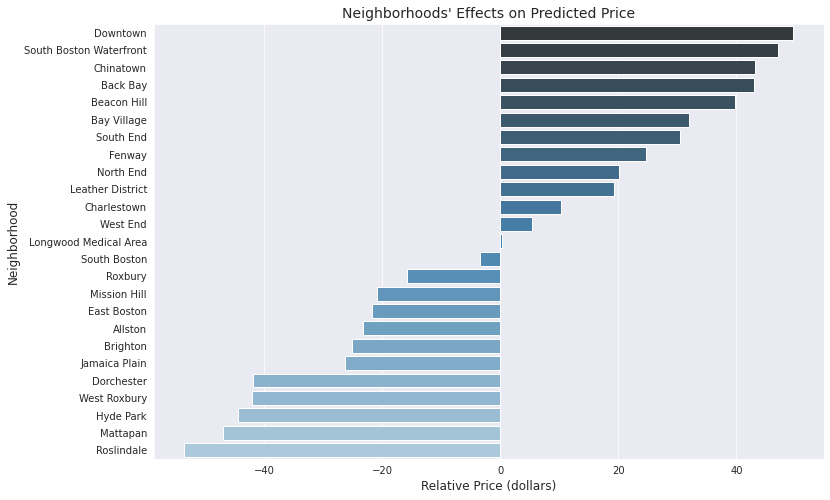

In [48]:
# Visualize neighborhood effect on price
plt.figure(figsize=(12, 8))
sns.barplot(data=neighborhoods, x='Coef', y='Var', palette='Blues_d')
plt.xlabel('Relative Price (dollars)', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.title("Neighborhoods' Effects on Predicted Price", fontsize=14);

In [49]:
# get the neighboorhood
property_type = coef_df[coef_df.Var.str.contains('property_type')].sort_values(by='Coef', ascending=False)
property_type['Var'] = property_type['Var'].apply(lambda x: x.split('_')[2])

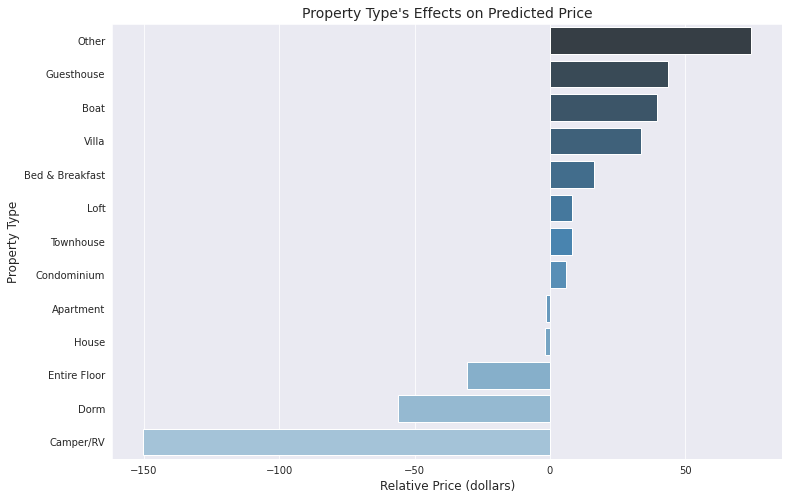

In [50]:
# Visualize property_type effect on price
plt.figure(figsize=(12, 8))
sns.barplot(data=property_type, x='Coef', y='Var', palette='Blues_d')
plt.xlabel('Relative Price (dollars)', fontsize=12)
plt.ylabel('Property Type', fontsize=12)
plt.title("Property Type's Effects on Predicted Price", fontsize=14);